<a href="https://colab.research.google.com/github/ljham/RNDL-shoes/blob/main/Proyecto_Programaci%C3%B3n_Deep_Learning_Grupo_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Programación: Dataset Shoes vs Sandals vs Boots
### Grupo 3: Guillermo Calderón Hernández, Luis Jama Tello y Guillermo Roberto Agusti
#### Link dataset: htps://bit.ly/3U0QpZj

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=896ddfdf75abc95c11d7c5c0fba252a625ef40f16ff4558353eb1b08b4feb45e
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [3]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luisjham","key":"7f5f28ed549ad4cd1ec09c72e701332c"}'}

In [4]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images --force


 83% 39.0M/47.0M [00:00<00:00, 101MB/s] 
100% 47.0M/47.0M [00:00<00:00, 106MB/s]


In [51]:
# Creemos un directorio para descomprimir los datos
!rm -R dataset/
!mkdir -p dataset

In [52]:
# Descomprimimos los datos y los dejamos listos para trabajar
# /content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip

# /content/dataset/Shoe vs Sandal vs Boot Dataset

!unzip -q shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d '/content/dataset/'
!mv /content/dataset/Shoe\ vs\ Sandal\ vs\ Boot\ Dataset/*  /content/dataset
!rm -R "/content/dataset/Shoe vs Sandal vs Boot Dataset"

In [ ]:
!pwd

/content


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report

batch_size = 32
img_size = (224, 224)
seed = 42

In [2]:
# Funciones base
def visualize_learning_curve(H):
  epochs = len(H.history["loss"])
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()


def evaluate_model(model, x, y):
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x, batch_size=batch_size)
  print(classification_report(y, predictions.argmax(axis=1)))

#### Preparación del Dataset

In [11]:
# dataset = image_dataset_from_directory("dataset/", label_mode="int", batch_size=batch_size, image_size=(102,136), validation_split=0.2, subset="both", shuffle=True, seed=seed)
# dataset = image_dataset_from_directory("/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset", label_mode="int", batch_size=batch_size, image_size=img_size, validation_split=0.2, subset="both", shuffle=True, seed=seed)

dataset = image_dataset_from_directory("dataset/", label_mode="int", batch_size=batch_size, image_size=(102,136), validation_split=0.2, subset="both", shuffle=True, seed=seed)


Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.


In [14]:
train_dataset = dataset[0]
val_dataset = dataset[1]

train_dataset_card = tf.data.experimental.cardinality(train_dataset).numpy()
val_dataset_card = tf.data.experimental.cardinality(val_dataset).numpy()

# Training Data
for data, labels in train_dataset.take(1):
    print('data.shape : ', data.shape)
    print('labels.shape : ', labels.shape)

class_names = train_dataset.class_names
print('class_names: ',class_names)

print(f"Dataset de Entrenamiento: %d muestras" % (train_dataset_card*batch_size))
print(f"Dataset de Validación: %d muestras" % (val_dataset_card*batch_size))

data.shape :  (32, 102, 136, 3)
labels.shape :  (32,)
class_names:  ['Boot', 'Sandal', 'Shoe']
Dataset de Entrenamiento: 12000 muestras
Dataset de Validación: 3008 muestras


#### Acondicionando el conjunto de datos

train_ds_pt_size :  300
Dataset de Entrenamiento: 9600 muestras
Dataset de Pruebas: 2400 muestras
(2400, 224, 224, 3)
(2400,)


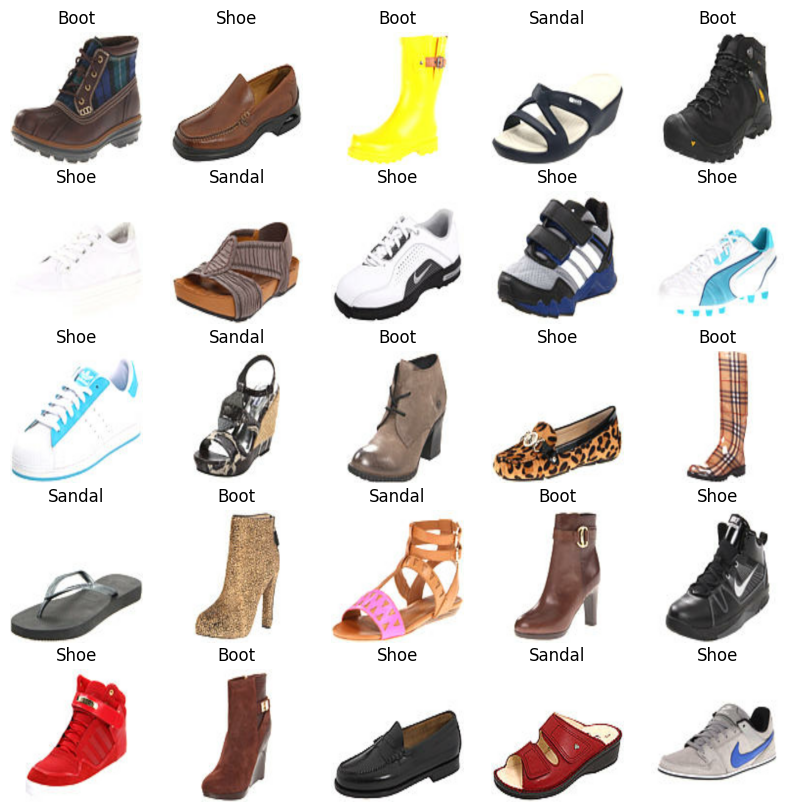

In [28]:
import tensorflow_datasets as tfds

# AUTO = tf.data.experimental.AUTOTUNE

# Normaliza las imágenes llevandolas al rango de [0,1]
# Función de Normalización de Imágenes
def process_image_normalize(image,label):
    image = tf.image.resize(image, img_size)
    image = tf.cast(image/255. ,tf.float32)
    return image,label

# Obtenemos el array con las imágenes y las etiquetas de test
# Para poder Evaluar los resultados con la librerìa de sklearn
def convert_dataset_to_numpy(test_dataset):
  # Convierte a numpy array cada elemento del tensor
  test_dict_numpy = tfds.as_numpy(test_dataset)

  # Convierte el diccionario de numpy array devuelto en
  # un array único para imagenes y etiquetas
  arr_test_label = []
  arr_test_image = []
  first_image = True
  for elem in test_dict_numpy:
    if first_image:
      arr_test_image = elem[0]
      arr_test_label = elem[1]
      first_image = False
    else:
      arr_test_image = np.vstack([arr_test_image, elem[0]])
      arr_test_label = np.hstack([arr_test_label, elem[1]])
  return arr_test_image, arr_test_label

# Aplica la Normalización en el dataset de Training y de Validación
train_ds_norm = train_dataset .map(process_image_normalize)
val_ds_norm = val_dataset.map(process_image_normalize)

# Calcula el 80% del tamaño del dataset de Training
train_ds_pt_size = int(tf.data.experimental.cardinality(train_ds_norm).numpy()*0.8)
print('train_ds_pt_size : ', train_ds_pt_size)

# Divide el dataset de entrenamiento en 80% entrenamiento y 20% para test
train_ds_pt = train_ds_norm.shuffle(batch_size,seed=seed).take(train_ds_pt_size).shuffle(batch_size)
test_ds_pt  = train_ds_norm.shuffle(batch_size,seed=seed).skip(train_ds_pt_size)

train_ds_pt_card = tf.data.experimental.cardinality(train_ds_pt).numpy()
print(f"Dataset de Entrenamiento: %d muestras" % (train_ds_pt_card*batch_size))
test_ds_pt_card = tf.data.experimental.cardinality(test_ds_pt).numpy()
print(f"Dataset de Pruebas: %d muestras" % (test_ds_pt_card*batch_size))

# Convierte Dataset a Numpy array
arr_test_image, arr_test_label = convert_dataset_to_numpy(test_ds_pt)

print(arr_test_image.shape)
# print(arr_test_image[0])
print(arr_test_label.shape)
# print(arr_test_label[0])

plt.figure(figsize=(10, 10))
for images, labels in train_ds_pt.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [29]:
print(arr_test_image[10, 50:110, 2])


[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


### Creando la arquitectura de una red Perceptron Multicapa

[INFO]: Entrenando la red neuronal...
Epoch 1/5
300/300 [==============================] - 195s 643ms/step - loss: 1.2221 - accuracy: 0.4803 - val_loss: 0.7176 - val_accuracy: 0.7200
Epoch 2/5
300/300 [==============================] - 196s 652ms/step - loss: 0.6154 - accuracy: 0.7360 - val_loss: 0.6078 - val_accuracy: 0.7327
Epoch 3/5
300/300 [==============================] - 192s 639ms/step - loss: 0.5122 - accuracy: 0.7902 - val_loss: 0.4295 - val_accuracy: 0.8367
Epoch 4/5
300/300 [==============================] - 195s 649ms/step - loss: 0.4463 - accuracy: 0.8189 - val_loss: 0.3859 - val_accuracy: 0.8650
Epoch 5/5
300/300 [==============================] - 196s 651ms/step - loss: 0.4022 - accuracy: 0.8400 - val_loss: 0.3164 - val_accuracy: 0.8797
[INFO]: Evaluando red neuronal...
75/75 [==============================] - 12s 158ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       805
           1       0.90      0.73     

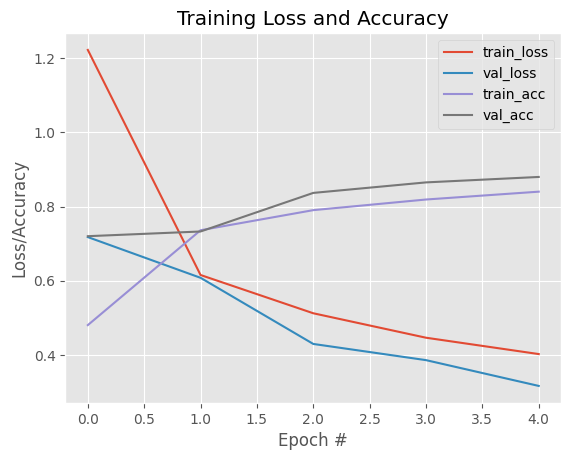

In [39]:
# Imports necesarios
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

# Arquitectura de red - modo API Sequential

mlp = Sequential()
mlp.add(Flatten())
mlp.add(Dense(2048, input_shape=(224*224*3,), activation="relu"))
mlp.add(Dense(1024, activation="relu"))
mlp.add(Dense(512, activation="relu"))
mlp.add(Dense(128, activation="relu"))
mlp.add(Dense(32, activation="relu"))
mlp.add(Dense(10, activation="softmax"))

# Compilamos el modelo y entrenamos

mlp.compile(optimizer=SGD(learning_rate=0.01),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

# Entrenamos el perceptrón multicapa
print("[INFO]: Entrenando la red neuronal...")
H = mlp.fit(train_ds_pt, epochs=5, steps_per_epoch=train_ds_pt_card, validation_data=val_ds_norm)

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(mlp, arr_test_image, arr_test_label)

#### Creando la Arquitectura de Red Neuronal Convolucional (CNN)

In [41]:
# Construccion de una red CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Red feedforward API secuencial
convnet = Sequential()

# BASE MODEL
# BM - Bloque Convolución 1
convnet.add(layers.Conv2D(32, (3,3), input_shape=(224,224,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# BM - Bloque Convolución 2
convnet.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# BM - Bloque Convolución 3
convnet.add(layers.Conv2D(128, (3,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# TOP MODEL
convnet.add(layers.Flatten())
convnet.add(layers.Dense(64, activation="relu"))
convnet.add(layers.Dense(3, activation="softmax"))

convnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 128)     

In [42]:
# Compilación
convnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [43]:
# Entrenamiento
H = convnet.fit(train_ds_pt, epochs=5, steps_per_epoch=train_ds_pt_card, validation_data=val_ds_norm)

Epoch 1/5


300/300 [==============================] - 226s 749ms/step - loss: 0.3761 - accuracy: 0.8626 - val_loss: 0.2866 - val_accuracy: 0.8723
Epoch 2/5
300/300 [==============================] - 228s 758ms/step - loss: 0.1653 - accuracy: 0.9401 - val_loss: 0.1483 - val_accuracy: 0.9590
Epoch 3/5
300/300 [==============================] - 230s 763ms/step - loss: 0.1121 - accuracy: 0.9620 - val_loss: 0.1335 - val_accuracy: 0.9560
Epoch 4/5
300/300 [==============================] - 233s 773ms/step - loss: 0.0653 - accuracy: 0.9770 - val_loss: 0.1167 - val_accuracy: 0.9643
Epoch 5/5
300/300 [==============================] - 228s 757ms/step - loss: 0.0468 - accuracy: 0.9837 - val_loss: 0.1239 - val_accuracy: 0.9643


[INFO]: Evaluando red neuronal...
75/75 [==============================] - 11s 143ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       805
           1       0.95      0.96      0.95       774
           2       0.96      0.95      0.95       821

    accuracy                           0.96      2400
   macro avg       0.96      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



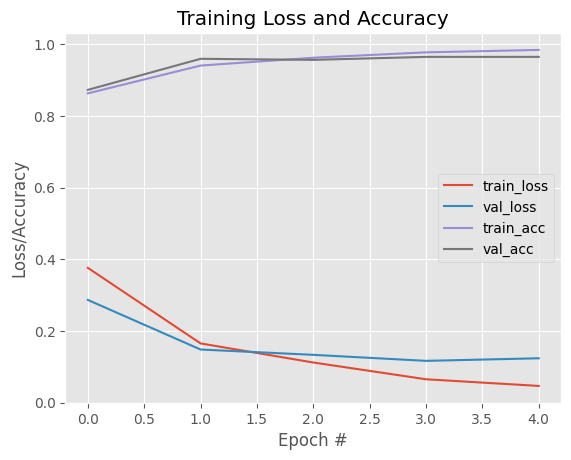

In [44]:
# Evaluación + Testeo
# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convnet, arr_test_image, arr_test_label)

**Modelo Base a partir de MobileNetV2**

In [30]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


**Extracción de características**

En este paso, congelará la base convolucional creada en el paso anterior y la utilizará como extractor de características. Además, agrega un clasificador encima y entrena el clasificador de nivel superior.

**Congelar la base convolucional**

Es importante congelar la base convolucional antes de compilar y entrenar el modelo. Congelar (estableciendo layer.trainable = False) evita que los pesos en una capa determinada se actualicen durante el entrenamiento. MobileNet V2 tiene muchas capas, por lo que establecer la bandera trainable de todo el modelo en False las congelará todas.
Creamos una función `fine_tunning` que permite establecer las capas que se van a descongelar.

In [31]:
def fine_tunning(trainable, fine_tune_at=30):
  base_model.trainable = trainable
  
  if trainable:
    # Mostramos la cantidad de layers que hay en el modelo
    print("Número de capas en el modelo base:  ", len(base_model.layers))

    # Congela todas las capas antes de la capa "fine_tune_at"
    for layer in base_model.layers[fine_tune_at:]:
      layer.trainable = False

fine_tunning(False)  
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**Definición del Top Model**

Cuando no se dispone de un conjunto de datos de imágenes grande, es una buena práctica introducir artificialmente diversidad de muestras mediante la aplicación de transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como la rotación y el volteo horizontal. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento y reduce el sobreajuste 

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 

def define_top_model(base_model):
    # Conectar el modelo con el top model
    model = Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
    ])
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(3, activation="softmax"))

    return model
    
top_model = define_top_model(base_model)

**Compilar el modelo - En Modo Transfer Learning**

In [33]:
top_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

**Entrenar al modelo - En Modo Transfer Learning**

In [34]:
H = top_model.fit(train_ds_pt, epochs=5, steps_per_epoch=train_ds_pt_card, validation_data=val_ds_norm)


Epoch 1/5


300/300 [==============================] - 167s 541ms/step - loss: 0.7595 - accuracy: 0.8698 - val_loss: 0.1640 - val_accuracy: 0.9453
Epoch 2/5
300/300 [==============================] - 168s 556ms/step - loss: 0.2666 - accuracy: 0.9198 - val_loss: 0.2441 - val_accuracy: 0.9347
Epoch 3/5
300/300 [==============================] - 166s 551ms/step - loss: 0.2005 - accuracy: 0.9396 - val_loss: 0.1290 - val_accuracy: 0.9597
Epoch 4/5
300/300 [==============================] - 166s 551ms/step - loss: 0.1961 - accuracy: 0.9397 - val_loss: 0.1708 - val_accuracy: 0.9570
Epoch 5/5
300/300 [==============================] - 166s 551ms/step - loss: 0.1947 - accuracy: 0.9421 - val_loss: 0.1386 - val_accuracy: 0.9603


**Evaluación y Testeo - Modo Tranfer Learning**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dropout (Dropout)           (None, 256)               0

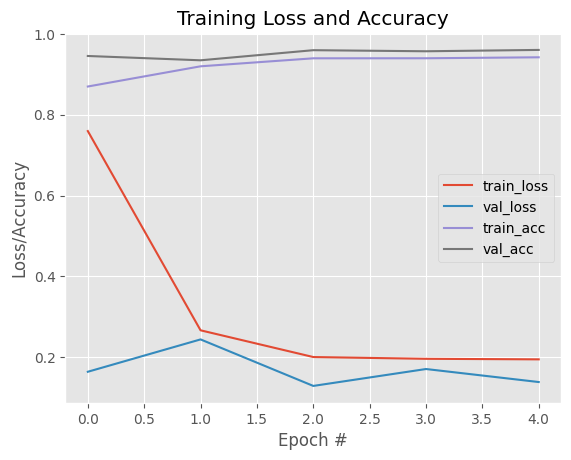

In [35]:
# Evaluación + Testeo

top_model.summary()

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(top_model, arr_test_image, arr_test_label)


**Descongelar el Base Model y Redefinir el Top Model para el Fine-Tunning**

In [36]:
fine_tunning(True)  
base_model.summary()

top_model = define_top_model(base_model)

Número de capas en el modelo base:   154
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )     

**Compilar el modelo - En Modo Fine-Tunning**

In [37]:
top_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

**Entrenar el Modelo - En Modo Fine-Tunning**

In [38]:
H = top_model.fit(train_ds_pt, epochs=5, steps_per_epoch=train_ds_pt_card, validation_data=val_ds_norm)

Epoch 1/5


300/300 [==============================] - 542s 2s/step - loss: 0.7303 - accuracy: 0.8673 - val_loss: 0.7179 - val_accuracy: 0.8127
Epoch 2/5
300/300 [==============================] - 533s 2s/step - loss: 0.2321 - accuracy: 0.9282 - val_loss: 0.2766 - val_accuracy: 0.9080
Epoch 3/5
300/300 [==============================] - 539s 2s/step - loss: 0.1840 - accuracy: 0.9425 - val_loss: 0.2797 - val_accuracy: 0.9290
Epoch 4/5
300/300 [==============================] - 542s 2s/step - loss: 0.1747 - accuracy: 0.9455 - val_loss: 0.3134 - val_accuracy: 0.9107
Epoch 5/5
300/300 [==============================] - 553s 2s/step - loss: 0.1591 - accuracy: 0.9519 - val_loss: 0.2282 - val_accuracy: 0.9177


**Evaluación y Testeo - Modo Fine-Tunning**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               16056576  
                                                                 
 dropout_2 (Dropout)         (None, 256)              

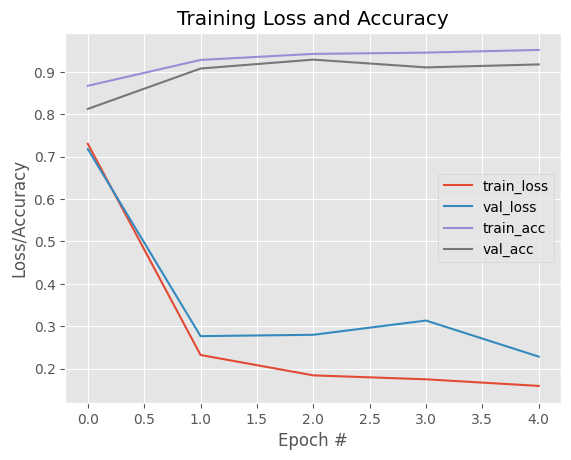

In [39]:
top_model.summary()

# Evaluación + Testeo
# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(top_model, arr_test_image, arr_test_label)